In [2]:
import numpy as np
from time import time
import pandas as pd
import math
import datetime
from arch import arch_model
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.font_manager import FontProperties
from urllib.request import urlretrieve
import os

### 导入数据

In [3]:
data = pd.read_excel(os.path.join(r"D:\UserData\Desktop\daimashuju","宝钢股份.xls")).dropna()

In [4]:
data["收盘价"] = data["收盘价"].apply(lambda x:round(x,2))

In [5]:
#set parameters
reps = 10000 # number of simulations
T = 3 # American option maturity date (in annum)
dt = 1/244 # time difference factor (244 trading days per annum)
# time = np.arange(0,T,dt) # time points
# N = len(time) # number of time intervals
N = data.shape[0] - 1
r = 3.77/100 # 无风险收益率——贴现率
sigma = 29.2326/100 # volatility历史波动率
S_0 = 6.40 # 初始价
K = 10 # 换股价

In [163]:
data

,证券代码,证券名称,交易时间,开盘价,最高价,最低价,收盘价,涨跌,涨跌幅%,成交量,成交额
0,600019,宝钢股份,2017-12-27,6.373213,6.510765,6.342646,6.40,——,——,63084280.0,5.316122e+08
1,600019,宝钢股份,2017-12-28,6.357929,6.640674,6.335004,6.61,0.213969,3.34528,94868348.0,8.112400e+08
2,600019,宝钢股份,2017-12-29,6.602466,6.686524,6.579540,6.60,-0.007641,-0.1156,43679600.0,3.786804e+08
3,600019,宝钢股份,2018-01-02,6.640674,6.869926,6.617749,6.85,0.244535,3.703699,109164698.0,9.691333e+08
4,600019,宝钢股份,2018-01-03,6.862284,7.030403,6.785867,6.82,-0.022925,-0.334817,84272829.0,7.609100e+08
...,...,...,...,...,...,...,...,...,...,...,...
700,600019,宝钢股份,2020-11-17,5.980255,6.026186,5.768971,5.84,-0.165353,-2.752296,111739526.0,7.167956e+08
701,600019,宝钢股份,2020-11-18,5.805716,5.952696,5.723039,5.80,-0.045931,-0.786164,120487116.0,7.636267e+08
702,600019,宝钢股份,2020-11-19,5.796529,5.851647,5.658735,5.78,-0.018373,-0.316958,106275032.0,6.657298e+08
703,600019,宝钢股份,2020-11-20,5.787344,5.980255,5.732225,5.96,0.183725,3.179645,119093760.0,7.636740e+08


In [239]:
import temp
import importlib
importlib.reload(temp)
reps = 1000
Price_instance = temp.Price_process(data)

In [240]:
# bond_price_simulate = {}
for i in range(94,245):
    try:
        p_temp = Price_instance.specific_day_price(i,reps,T,sigma,K)
        bond_price_simulate.update({Price_instance.data.iloc[i,2].strftime("%Y-%m-%d"):p_temp})
    except:
        reps = 10000
        p_temp = Price_instance.specific_day_price(i,reps,T,sigma,K)
        bond_price_simulate.update({Price_instance.data.iloc[i,2].strftime("%Y-%m-%d"):p_temp})
        reps = 1000

------------caculate_回售---------------
------------caculate赎回---------------
------------其他类型---------------
------------caculate_回售---------------
------------caculate赎回---------------
------------其他类型---------------
------------caculate_回售---------------
------------caculate赎回---------------
------------其他类型---------------
------------caculate_回售---------------
------------caculate赎回---------------
------------其他类型---------------
------------caculate_回售---------------
------------caculate赎回---------------
------------其他类型---------------
------------caculate_回售---------------
------------caculate赎回---------------
------------其他类型---------------
------------caculate_回售---------------
------------caculate赎回---------------
------------其他类型---------------
------------caculate_回售---------------
------------caculate赎回---------------
------------其他类型---------------
------------caculate_回售---------------
------------caculate赎回---------------
------------其他类型---------------
------------caculat

------------caculate赎回---------------
------------其他类型---------------
------------caculate_回售---------------
------------caculate赎回---------------
------------其他类型---------------
------------caculate_回售---------------
------------caculate赎回---------------
------------其他类型---------------
------------caculate_回售---------------
------------caculate赎回---------------
------------其他类型---------------
------------caculate_回售---------------
------------caculate赎回---------------
------------其他类型---------------
------------caculate_回售---------------
------------caculate赎回---------------
------------其他类型---------------
------------caculate_回售---------------
------------caculate赎回---------------
------------其他类型---------------
------------caculate_回售---------------
------------caculate赎回---------------
------------其他类型---------------
------------caculate_回售---------------
------------caculate赎回---------------
------------其他类型---------------
------------caculate_回售---------------
------------caculat

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

In [243]:
pd.DataFrame(bond_price_simulate,index=["price"]).T.to_csv(os.path.join(os.getcwd(),"temp.csv"))

In [8]:
#simulate Geometric Brownian Motion
def underlying_price(reps, N, S_0, r, sigma, dt):    
    '''
    Simulate the underlying stock price paths by Geometric Brownian motion with mean "r" and volatility "sigma".

    Args:
        reps: number of simulated underlying price paths generated by Geometric Brownian Motion
        N: number of time intervals until maturity
        S_0: initial stock price
        r: (annualized) riskfree interest rate (mean of the GBM)
        sigma: (annualized) volatility (standard deviation) of the GBM
        dt: time difference factor
        
    Return:
        S: the matrix of the underlying stock price paths given in each discretized time point (in numpy.array)
    
    '''
    S = np.empty([reps,N+1]) # 'reps' sample paths of GBM(r,sigma) movement
    for i in range(reps):    
        one_path = S_0*np.cumprod(np.exp((r-(sigma**2)/2)*dt + sigma*np.sqrt(dt)*np.random.normal(0,1,N))) # one GBM increment
        one_path = np.insert(one_path,0,S_0) # add the initial stock price at inception
        S[i,] = one_path
    res= pd.DataFrame(S,index = np.arange(reps),columns = data_time.values.flatten()).applymap(lambda x:round(x,2))
    return S,res

##### 模拟资产路径

In [115]:
import matplotlib.pyplot as plt
up,df = underlying_price(reps,N,S_0,r,sigma,dt)

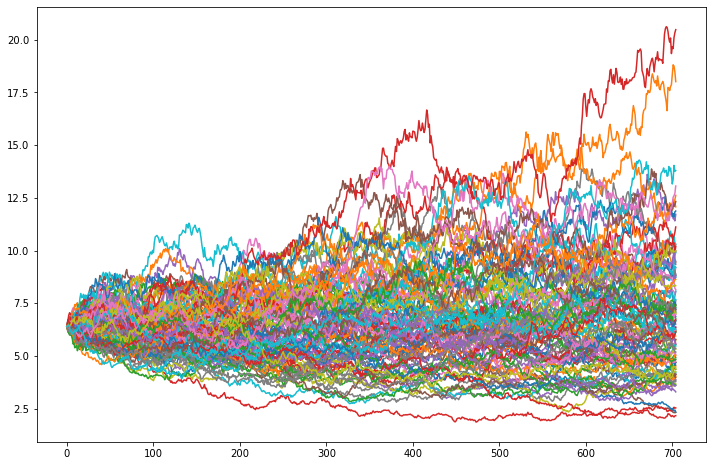

In [116]:
fig = plt.figure(figsize = (12,8))
up_plot = up[np.random.permutation(100)]
for i in range(up_plot.shape[0]):
    _ =plt.plot(up_plot[i])
#     plt.legend()

##### 赎回条款,日期限制

In [11]:
from dateutil.parser import parse
ipo_day = parse("2017-12-28")#上市日期;
ipo_day_ind = df.columns.get_loc(ipo_day)
huangu_start_day = parse("2018-11-29")#换股开始日
huangu_start_day_ind = df.columns.get_loc(huangu_start_day)
maturity_day = parse("2020-11-23")#债券到期日前一天
maturity_day_ind = df.columns.get_loc(maturity_day)
rate_start_day = parse("2017-11-24")
gap_day = df.columns.get_loc(huangu_start_day) - df.columns.get_loc(ipo_day)
bond_rate_gap_year = gap_day + 24 #24是上市日-起息日

In [12]:
#换股日开始后一段时间内，达到K的1.3倍，立即换股，这段时间一直持续到到期
#判断是否赎回，最近30个交易日有15个高于1.3
#票面利率
bond_paper_rate = 0.01 #年化
def Judge_redeem(x:np.ndarray,S):
    data = x.flatten()
    for i in range(30,x.shape[0]):
        temp_data = data[i-30:i]
        if (np.sum(temp_data >= S) >=15):
            temp_data_index = np.where(np.sum(temp_data >= S)>=15)[0][0]
            target_index = temp_data_index + i
            break;
    else:
        target_index = None
    return target_index

def redeem_discount(x,target_index):#x是起息日之后的数据
    target_data = x[:target_index+1]
    target_price = target_data[-1]
    all_year = (target_index + bond_rate_gap_year)/244
    discount_year = (target_index + gap_day)/244
    res = (100*target_price/K + 100*bond_paper_rate*all_year)*np.exp(-r*discount_year)
    return res

def get_redeem_price(x:np.ndarray,S):
    #select_date_span
    x = x[huangu_start_day_ind:]
    target_index = Judge_redeem(x,S)
    if target_index:
        price = redeem_discount(x,target_index)#target_index是从换股起息日开始计算
        return price
    else: #没有满足
        return None

In [ ]:
def get_redeem_sell_back(x:np.ndarray,S,bond_paper_rate,df_shape1,r):
    """
    倒数244个交易日
    """
    x = x[-244:]
    target_index = Judge_sell_back(x,S)
    if target_index:
        price = redeem_discount_sell_back(df_shape1,x,target_index,bond_paper_rate,r)
        return price
    else:
        return None

In [15]:
#回售条款 任意连续30个交易日
def Judge_sell_back(x:np.ndarray,S):
    #最后244个交易日
    data = x.flatten()
    for i in range(30,x.shape[0]):
        temp_data = data[i-30:i]
        if (temp_data <= S).all():
            return i
    else:
        return None
    
def redeem_discount_sell_back(x,target_index):#
    target_data = x
    all_year_num = (df.shape[1] - 244 + target_index);
    all_year = all_year_num/244
    discount_year = (all_year_num + 24)/244
#     set_trace()
    res = (100 + 100*bond_paper_rate*all_year)*np.exp(-r*discount_year) 
    return res

def get_redeem_sell_back(x:np.ndarray,S):
    """
    倒数244个交易日
    """
    x = x[-244:]
    target_index = Judge_sell_back(x,S)
    if target_index:
        price = redeem_discount_sell_back(x,target_index)
        return price
    else:
        return None

##### 最小二乘

In [132]:
from pdb import set_trace
def least_square_monte_carlo(df,Price,K):
    """
    Price:行权价
    K:基本行权价 Price = K
    df:所有有效路径
    """
    value = np.empty([df.shape[0],df.shape[1]])
    for i in range(df.shape[1]-1,-1,-1):
        S_current = df[:,i]
        if i == df.shape[1] - 1:     
            def judge_end(nd:np.ndarray,Price):
                if nd > Price:
                    return nd*100/K
                elif nd <= Price:
                    return Price*100/K
            judge_np = np.vectorize(judge_end)
            value[:,i] = judge_np(S_current,Price)
        elif i == 0:
            for z in range(df.shape[0]):
                current_path = value[z,1:]
                nonzero_loc = current_path.nonzero()
                if len(nonzero_loc[0]) == 0:
                    value[z,i] = 0
                else:
                    first_nonzero_loc = nonzero_loc[0][0]
                    dt = 1/244
                    value[z,i] = np.exp(-r*dt*(first_nonzero_loc + 1))*current_path[first_nonzero_loc]
        else:
            in_the_money_loc = ((S_current - Price)*(S_current>Price)).nonzero()
            length = len(in_the_money_loc[0])
            exercise_value = ((S_current*100/K) * (S_current > Price))[in_the_money_loc]
            X = np.empty([length,2])
            for j in range(1,3):
                X[:,j-1] = np.power(S_current[in_the_money_loc],j)
            previous_continuation_value = value[:,i + 1][in_the_money_loc]
            dt = 1/244
            Y = np.exp(-r*dt)*previous_continuation_value
            try:
                length >=10
            except:
                raise Exception("实值行情少于10行")
            predicted_conditional_exp = LinearRegression().fit(X, Y).predict(X)
            value[:,i] = [0]*df.shape[0]
            exercise_immediate_loc = (exercise_value > predicted_conditional_exp)
            optimal_loc = in_the_money_loc[0][exercise_immediate_loc]
            optimal_cash_flow = exercise_value[exercise_immediate_loc]
            value[optimal_loc,i] = optimal_cash_flow
    return value

In [118]:
res_sh = {}
for i in range(df.shape[0]):
    price = get_redeem_price(df.values[i],1.3*K)
    res_sh.update({i:price})
    
res_hs = {}
for i in range(df.shape[0]):
    price = get_redeem_sell_back(df.values[i],0.7*K)
    res_hs.update({i:price})
    
other_type = []
for u in res_sh.keys():
    if (res_sh[u] is None) & (res_hs[u] is None):
        other_type.append(u)

In [92]:
import warnings
warnings.filterwarnings("ignore")
temp1 = df.values[[other_type]]
Price = K = 10

In [150]:
df.iloc[:,224]

0        6.17
1        4.80
2        7.44
3        8.01
4        4.67
        ...  
9995     5.69
9996     5.88
9997     4.90
9998     6.66
9999    10.24
Name: 2018-11-29 00:00:00, Length: 10000, dtype: float64

In [93]:
value = np.empty([temp1.shape[0],temp1.shape[1]])

In [133]:
p1 = least_square_monte_carlo(df.values[other_type,224:],10,10)

In [151]:
(pd.Series(res_sh).sum(skipna=True) + pd.Series(res_hs).sum(skipna=True) + p1[:,0].sum()*np.exp(-r*gap_day/244))/10000

98.4072170141083